 # HoVerNet - The CoNIC Baseline

 ## About this notebook
 In this notebook, we provide a pretrained
 [HoVerNet](https://arxiv.org/abs/1812.06499)
 as the baseline model for the CoNIC training data.
 The HoVerNet utilized here was trained using
 only data from the CoNIC training set. You can download the pretrained
 weights [here](https://drive.google.com/file/d/1oVCD4_kOS-8Wu-eS5ZqzE30F9V3Id78d/view?usp=sharing).

 In the making of the baseline model, we perform following steps:
 - Generating training and validation split.
 - Perform the inference to get raw output.
 - Perform the post-processing to convert the output into an approriate form
 for the evaluation process in `compute_stats.py`.

 All in all, the HoVerNet trained on the data split obtained
 from this notebook achieved the validation results as follows:

 **Nucleus Instance Segmentation and Classification**
 --------------------------
 | PQ     | Multiclass-PQ+|
 |--------|---------------|
 | 0.6149 | 0.4998        |
 --------------------------

 **Cell Composition**
 ----------
 |   R2   |
 |--------|
 | 0.8585 |
 ----------

 ## Importing Libraries and Workspace Settings
 We import some Python modules that are utilized throughout the notebook.

 > **Note**: We use `tiatoolbox` extensively in this repository.
 > You can refer to [here](https://github.com/TissueImageAnalytics/tiatoolbox) for installation instructions.
 > For this notebook, we use the `develop` branch rather than `master`.

 We also declare the folders which contain the input
 data and the output.

In [2]:
import sys
import logging
import os

import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.utils import io as IPyIO
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 300

# adding the project root folder
sys.path.append('../')
from tiatoolbox.models import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.visualization import overlay_prediction_contours

from misc.utils import cropping_center, recur_find_ext, rm_n_mkdir, rmdir

# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For CoNIC, we have 6 types in total.
NUM_TYPES = 7
# The path to the directory containg images.npy etc.
DATA_DIR = '../exp_output/data/'
# The path to the pretrained weights
PRETRAINED = '../exp_output/hovernet-conic.pth'
# The path to contain output and intermediate processing results
OUT_DIR = '../exp_output/'

 # Generating Data Splits
 Here, we show how the training data is split into the training
 and validation subset. CoNIC training data comes from multiple
 sources. In order to ensure that the model receives a balance
 amount of information for each source, we stratifically split them
 according to their origin.

 For the baseline model, we utilize 80% the number of the patches
 for training and the remaining for validation. However, because
 we stratifically split them accordintg to their origin, the final
 number of patches. Therefore, we generate a number splits (indicate
 via the `NUM_TRIALS` variable) and select the one that have the
 number of patches that closely match our expected ratio.

 Lastly, to ensure the reproducibility
 of the splitting, we also provide the random seed.

In [3]:
NUM_TRIALS = 10
TRAIN_SIZE = 0.8
VALID_SIZE = 0.2

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

info = pd.read_csv(f'{DATA_DIR}/patch_info.csv')
file_names = np.squeeze(info.to_numpy()).tolist()

img_sources = [v.split('-')[0] for v in file_names]
img_sources = np.unique(img_sources)

cohort_sources = [v.split('_')[0] for v in img_sources]
_, cohort_sources = np.unique(cohort_sources, return_inverse=True)

splitter = StratifiedShuffleSplit(
    n_splits=NUM_TRIALS,
    train_size=TRAIN_SIZE,
    test_size=VALID_SIZE,
    random_state=SEED
)

splits = []
split_generator = splitter.split(img_sources, cohort_sources)
for train_indices, valid_indices in split_generator:
    train_cohorts = img_sources[train_indices]
    valid_cohorts = img_sources[valid_indices]
    assert np.intersect1d(train_cohorts, valid_cohorts).size == 0
    train_names = [
        file_name
        for file_name in file_names
        for source in train_cohorts
        if source == file_name.split('-')[0]
    ]
    valid_names = [
        file_name
        for file_name in file_names
        for source in valid_cohorts
        if source == file_name.split('-')[0]
    ]
    train_names = np.unique(train_names)
    valid_names = np.unique(valid_names)
    print(f'Train: {len(train_names):04d} - Valid: {len(valid_names):04d}')
    assert np.intersect1d(train_names, valid_names).size == 0
    train_indices = [file_names.index(v) for v in train_names]
    valid_indices = [file_names.index(v) for v in valid_names]
    splits.append({
        'train': train_indices,
        'valid': valid_indices
    })
joblib.dump(splits, f"{OUT_DIR}/splits.dat")

Train: 3963 - Valid: 1018
Train: 4053 - Valid: 0928
Train: 3952 - Valid: 1029
Train: 3988 - Valid: 0993
Train: 3997 - Valid: 0984
Train: 4002 - Valid: 0979
Train: 3894 - Valid: 1087
Train: 4012 - Valid: 0969
Train: 3988 - Valid: 0993
Train: 3964 - Valid: 1017


['exp_output//splits.dat']

 # Inference
 To further simplify the inference process, we utilize `tiatoolbox`
 which already contains the inference mechanism. Despite their convenience,
 their functionality does not support using an array as input. Therefore,
 we will turn `images.npy` into individual `*.png` for the inference process.

 > **Note**: We use the first fold (trial) from the splits generated above
 > for training. Therefore, we need to extract the corresponding ground truth
 > for the evaluation process.

In [3]:
# The fold to use
FOLD_IDX = 0

In [4]:
imgs = np.load(f'{DATA_DIR}/images.npy')
labels = np.load(f'{DATA_DIR}/labels.npy')

splits = joblib.load(f'{OUT_DIR}/splits.dat')
valid_indices = splits[FOLD_IDX]['valid']

rm_n_mkdir(f'{OUT_DIR}/imgs/')
for idx in valid_indices:
    img = imgs[idx]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{OUT_DIR}/imgs/{idx:04d}.png', img)

valid_labels = labels[valid_indices]
np.save(f'{OUT_DIR}/valid_true.npy', valid_labels)

In [5]:
from net_desc import HoVerNetConic

pretrained = torch.load(PRETRAINED)
model = HoVerNetConic(num_types=NUM_TYPES)
model.load_state_dict(pretrained)

# Tile prediction
predictor = SemanticSegmentor(
    model=model,
    num_loader_workers=2,
    batch_size=6,
)

In [10]:
ioconfig = IOSegmentorConfig(
    input_resolutions=[
        {'units': 'mpp', 'resolution': 0.5},
    ],
    output_resolutions=[
        {'units': 'mpp', 'resolution': 0.5},
        {'units': 'mpp', 'resolution': 0.5},
        {'units': 'mpp', 'resolution': 0.5},
    ],
    save_resolution={'units': 'mpp', 'resolution': 0.5},
    patch_input_shape=[256, 256],
    patch_output_shape=[256, 256],
    stride_shape=[256, 256],
)

logger = logging.getLogger()
logger.disabled = True

infer_img_paths = recur_find_ext(f'{OUT_DIR}/imgs/', ['.png'])
rmdir(f'{OUT_DIR}/raw/')

# capture all the printing to avoid cluttering the console
with IPyIO.capture_output() as captured:
    output_file = predictor.predict(
        infer_img_paths,
        masks=None,
        mode='tile',
        on_gpu=True,
        ioconfig=ioconfig,
        crash_on_exception=True,
        save_dir=f'{OUT_DIR}/raw/'
    )

|2021-12-15|22:59:39.355| [WARNING] /home/dang/storage_1/workspace/nuclei/conic-challenge/notebooks/../../../tiatoolbox/tiatoolbox/models/engine/semantic_segmentor.py:1025: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2021-12-15|22:59:39.467| [WARNING] /home/dang/storage_1/workspace/nuclei/conic-challenge/notebooks/../../../tiatoolbox/tiatoolbox/models/engine/semantic_segmentor.py:274: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2021-12-15|22:59:39.478| [WARNING] /home/dang/storage_1/workspace/nuclei/conic-challenge/notebooks/../../../tiatoolbox/tiatoolbox/wsicore/wsimeta.py:171: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2021-12-15|22:59:39.479| [WARNING] /home/dang/storage_1/workspace/nuclei/conic-challenge/notebooks/../../../tiatoolbox/tiatoolbox/wsicore/wsimeta.py:1

 Once we have the HoVerNet raw inference output, we apply post processing
 to obtain the final results. For CoNIC, there are two tasks that
 are linked with each other:
 - The instance segmentation and detection of nuclei.
 - The compositions of nuclei types within the provided patches.
 Rathet than directly predicting the 2nd set of results from images, we simply
 the final output of HoVerNet. Thus, to make the code more organized, we
 encapsulate these two stages into their our funtions.

In [11]:
def process_segmentation(np_map, hv_map, tp_map):
    # HoVerNet post-proc is coded at 0.25mpp so we resize
    np_map = cv2.resize(np_map, (0, 0), fx=2.0, fy=2.0)
    hv_map = cv2.resize(hv_map, (0, 0), fx=2.0, fy=2.0)
    tp_map = cv2.resize(
                    tp_map, (0, 0), fx=2.0, fy=2.0,
                    interpolation=cv2.INTER_NEAREST)

    inst_map = model._proc_np_hv(np_map[..., None], hv_map)
    inst_dict = model._get_instance_info(inst_map, tp_map)

    # generating results match with the evaluation protocols
    type_map = np.zeros_like(inst_map)
    inst_type_colours = np.array([
        [v['type']] * 3 for v in inst_dict.values()
    ])
    type_map = overlay_prediction_contours(
        type_map, inst_dict,
        line_thickness=-1,
        inst_colours=inst_type_colours)

    pred_map = np.dstack([inst_map, type_map])
    # the result for evaluation is at 0.5mpp so we scale back
    pred_map = cv2.resize(
                    pred_map, (0, 0), fx=0.5, fy=0.5,
                    interpolation=cv2.INTER_NEAREST)
    return pred_map

In [12]:
def process_composition(pred_map):
    # only consider then 224x224 center, as noted in the challenge
    # description paper
    pred_map = cropping_center(pred_map, [224, 224])
    inst_map = pred_map[..., 0]
    type_map = pred_map[..., 1]
    # ignore 0-th index as it is 0 i.e background
    uid_list = np.unique(inst_map)[1:]

    if len(uid_list) < 1:
        type_freqs = np.zeros(NUM_TYPES)
        return type_freqs
    uid_types = [
        np.unique(type_map[inst_map == uid])
        for uid in uid_list
    ]
    type_freqs_ = np.unique(uid_types, return_counts=True)
    # ! not all type exists within same spatial location
    # ! so we have to create a place holder and put them there
    type_freqs = np.zeros(NUM_TYPES)
    type_freqs[type_freqs_[0]] = type_freqs_[1]
    return type_freqs

 Now we actually perform the post-processing using the input
 output file mapping obtained previously from the inference process.

In [13]:
output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

semantic_predictions = []
composition_predictions = []
for input_file, output_root in tqdm(output_info):
    img = cv2.imread(input_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    np_map = np.load(f'{output_root}.raw.0.npy')
    hv_map = np.load(f'{output_root}.raw.1.npy')
    tp_map = np.load(f'{output_root}.raw.2.npy')

    pred_map = process_segmentation(np_map, hv_map, tp_map)
    type_freqs = process_composition(pred_map)
    semantic_predictions.append(pred_map)
    composition_predictions.append(type_freqs)
semantic_predictions = np.array(semantic_predictions)
composition_predictions = np.array(composition_predictions)

 25%|██▍       | 250/1018 [00:15<00:33, 22.84it/s]|2021-12-15|23:03:00.234| [WARNING] /home/dang/storage_1/workspace/nuclei/conic-challenge/notebooks/../../../tiatoolbox/tiatoolbox/models/architecture/hovernet.py:491: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  blb = remove_small_objects(blb, min_size=10)

|2021-12-15|23:03:00.269| [WARNING] /home/dang/storage_1/workspace/nuclei/conic-challenge/notebooks/../../../tiatoolbox/tiatoolbox/models/architecture/hovernet.py:555: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  marker = remove_small_objects(marker, min_size=obj_size)

100%|██████████| 1018/1018 [01:10<00:00, 14.35it/s]


In [14]:
# Saving the results for segmentation
np.save(f'{OUT_DIR}/valid_pred.npy', semantic_predictions)

# Saving the results for regression
TYPE_NAMES = [
    "neutrophil", "epithelial", "lymphocyte",
    "plasma", "eosinophil", "connective"
]
df = pd.DataFrame(
    composition_predictions[:, 1:].astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_pred_cell.csv', index=False)

# Load up the composition ground truth and
# save the validation portion
df = pd.read_csv(f'{DATA_DIR}/counts.csv')
true_compositions = df.to_numpy()[valid_indices]
df = pd.DataFrame(
    true_compositions.astype(np.int32),
)
df.columns = TYPE_NAMES
df.to_csv(f'{OUT_DIR}/valid_true_cell.csv', index=False)

 # Visualization
 To wrap everything up, we randomly select some samples within the validation
 set and plot their associated ground truth and predictions

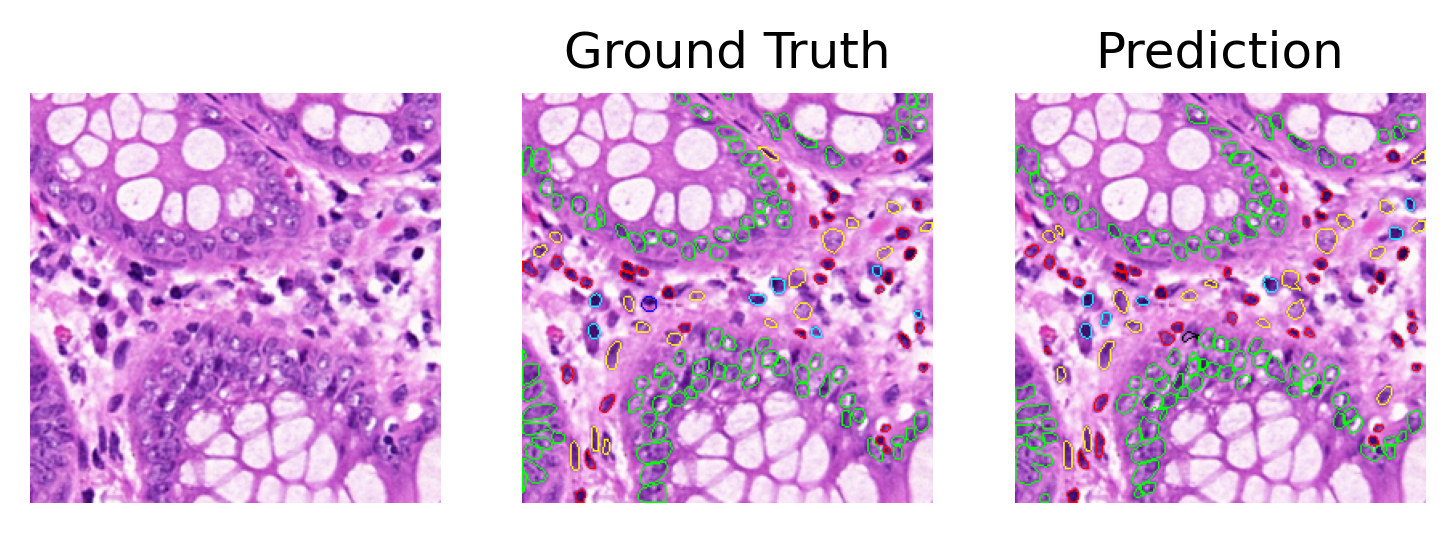

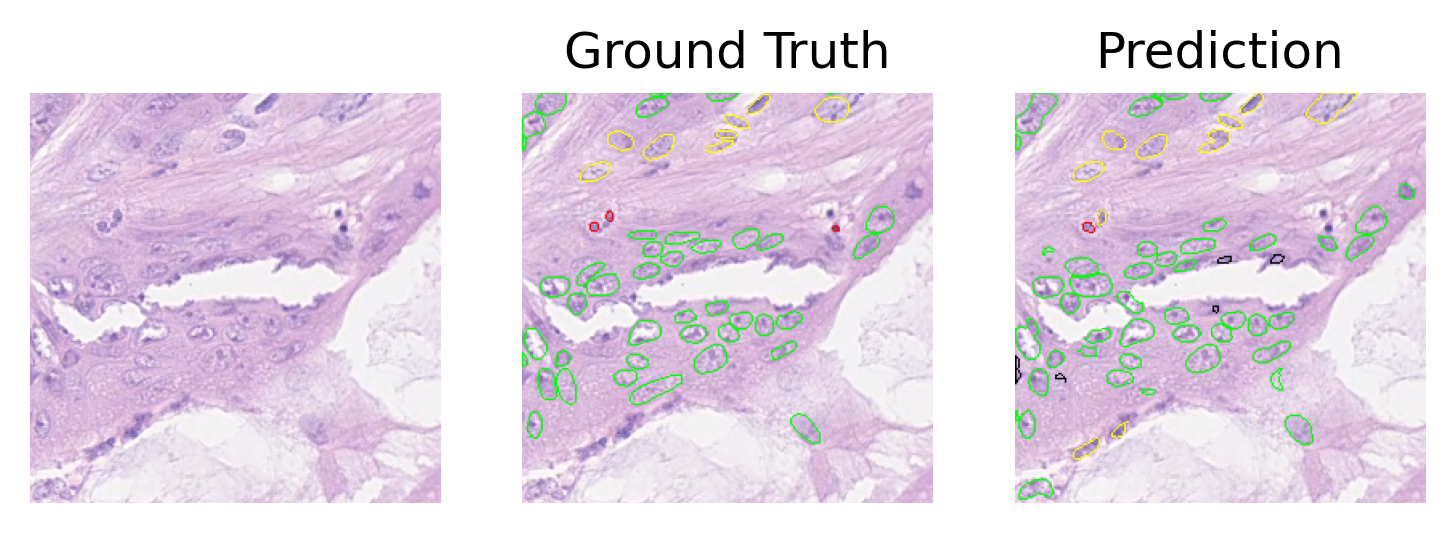

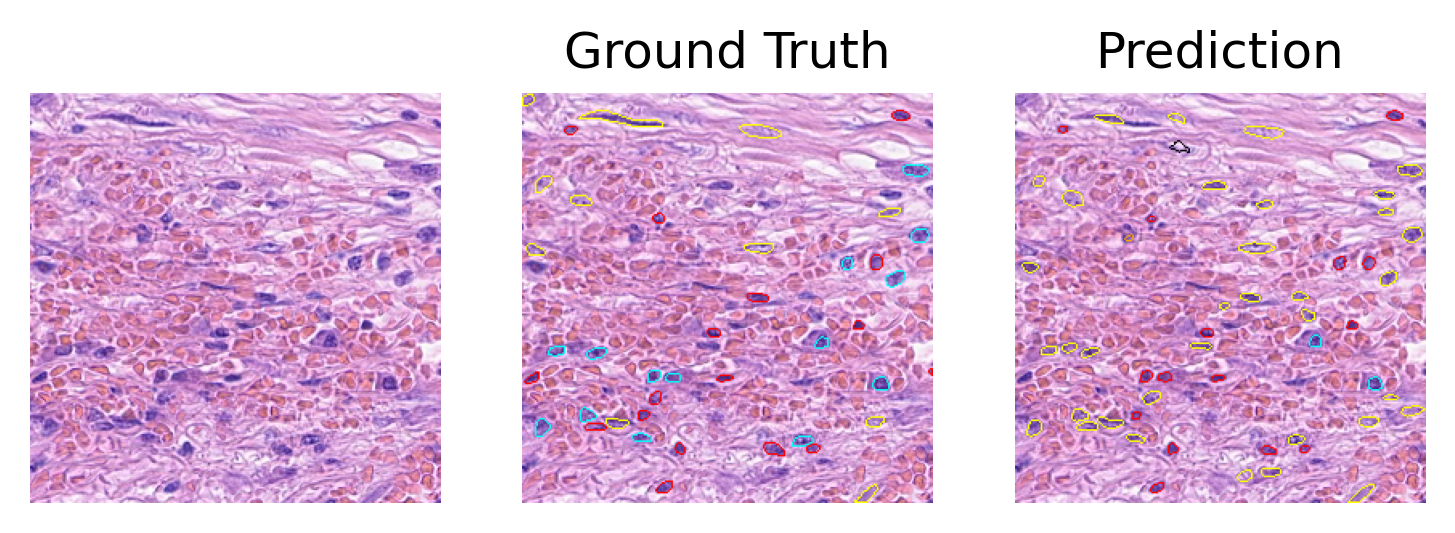

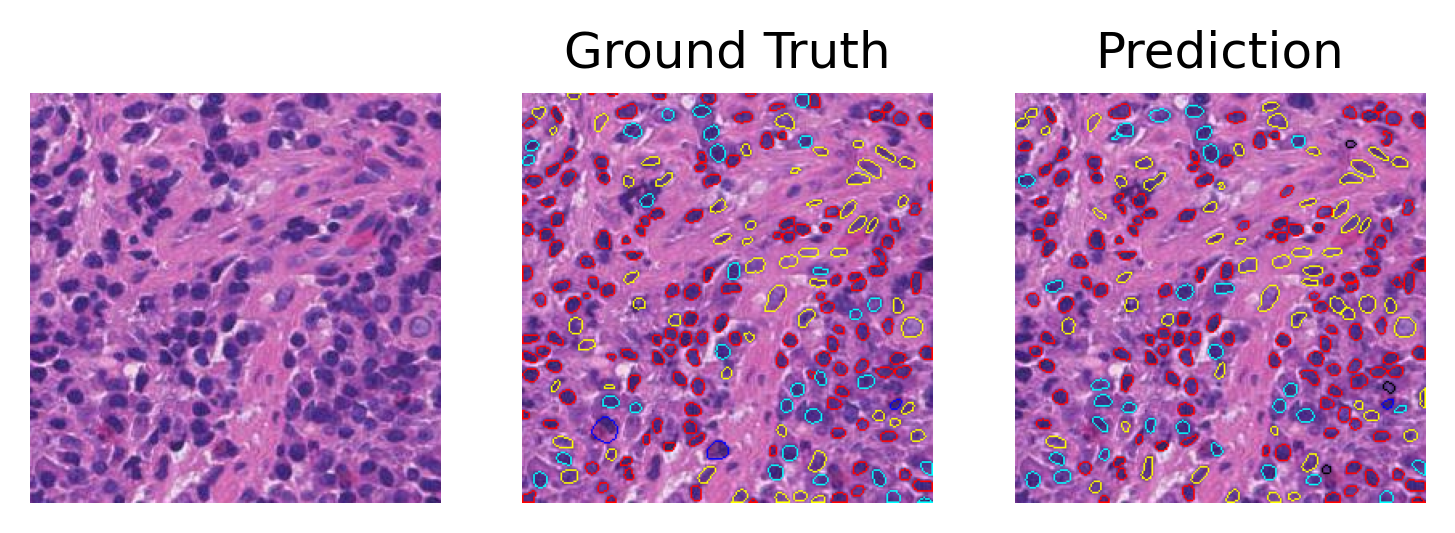

In [16]:
semantic_true = np.load(f'{OUT_DIR}/valid_true.npy')
semantic_pred = np.load(f'{OUT_DIR}/valid_pred.npy')

output_file = f'{OUT_DIR}/raw/file_map.dat'
output_info = joblib.load(output_file)

np.random.seed(SEED)
selected_indices = np.random.choice(len(valid_indices), 4)

PERCEPTIVE_COLORS = [
    (  0,   0,   0),
    (255, 165,   0),
    (  0, 255,   0),
    (255,   0,   0),
    (  0, 255, 255),
    (  0,   0, 255),
    (255, 255,   0),
]

for idx in selected_indices:
    img = cv2.imread(output_info[idx][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inst_map = semantic_pred[idx][..., 0]
    type_map = semantic_pred[idx][..., 1]
    pred_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_map = semantic_true[idx][..., 0]
    type_map = semantic_true[idx][..., 1]
    true_inst_dict = model._get_instance_info(inst_map, type_map)

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in true_inst_dict.values()
    ])
    overlaid_true = overlay_prediction_contours(
        img, true_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    inst_type_colours = np.array([
        PERCEPTIVE_COLORS[v['type']]
        for v in pred_inst_dict.values()
    ])
    overlaid_pred = overlay_prediction_contours(
        img, pred_inst_dict,
        inst_colours=inst_type_colours,
        line_thickness=1
    )

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(overlaid_true)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(overlaid_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()